# Ejercicio 2

In [11]:
# Importacion de librerias
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats

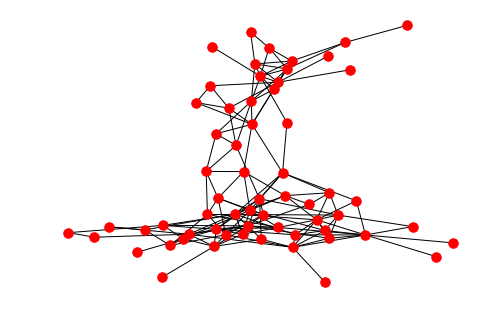

In [28]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=90)
plt.show()

In [14]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')
data_gender
colores=[]

# Le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
# Creamos un vector de colores que vincula los generos (mismo orden)     
for node in G.node:
    gen = G.node[node]['genero']
    #print(node,gen)
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')
        


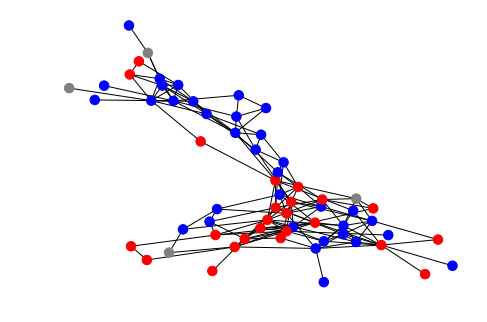

In [15]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_grouping='genero',node_size=90)
plt.show()

Este primer gráfico muestra que la red está compuesta por dos "comunas", a primera vista no se puede distinguir si es una red homofílica. 

Utilizamos otros layouts para representar la red. 

Le asignamos colores distintos segun el tipo de enlaces. Los enlaces homofilicos (macho-macho o hembra-hembra) tendrán color purpura. Los enlaces heterofilicos (hembra-macho) tendran color verde. Esto nos permite tener una primera idea "visual" de la cantidad de enlaces de cada tipo. 

Los enlaces que involucran delfines con género indeterminado serán excluidos.

In [16]:
# Creamos una lista de enlaces homofilicos y otra lista de enlaces heterofilicos
lista_hetero =[]
lista_homo = []
for i in range(0,len(list(G.edges))):
    if(G.node[list(G.edges)[i][0]]['genero']!='NA' and G.node[list(G.edges)[i][1]]['genero']!='NA'):     
        if G.node[list(G.edges)[i][0]]['genero']==G.node[list(G.edges)[i][1]]['genero']:
            lista_homo +=[(list(G.edges)[i][0],list(G.edges)[i][1])] 
        else:
            lista_hetero+=[(list(G.edges)[i][0],list(G.edges)[i][1])] 
    else:
        pass

            Gráfico con layout random

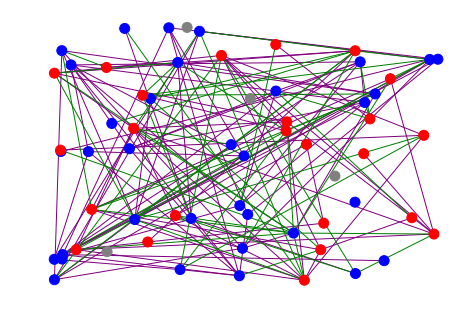

In [31]:
pos=nx.random_layout(G)
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=100,pos=pos,edge_width=0.1,edge_color='w')
nx.draw_networkx_edges(G,pos,edgelist=lista_homo,width=1,alpha=1,edge_color='purple')
nx.draw_networkx_edges(G,pos,edgelist=lista_hetero,width=1,alpha=1,edge_color='green')
plt.show()

Gráfico con layout circular

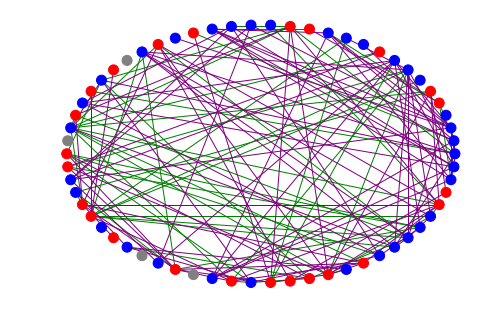

In [29]:
pos=nx.shell_layout(G)
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=100,pos=pos,edge_width=0.1,edge_color='w')
nx.draw_networkx_edges(G,pos,edgelist=lista_hetero,width=1,alpha=1,edge_color='green')
nx.draw_networkx_edges(G,pos,edgelist=lista_homo,width=1,alpha=1,edge_color='purple')
plt.show()

A primera impresión los gráficos parecen mostrar que prevalecen los enlaces homofilicos por sobre los enlaces heterofílicos. 

In [5]:
## calcula la fraccion de enlaces entre nodos de distinto genero
def fraccion_mh(G): 
    A = nx.adjacency_matrix(G)  # Matriz de adycencia
    v=0
    enlaces = 0.0  # cantidad de enlaces (excluyendo los NA)
    union_mh = 0.0 # cantidad de enlaces macho-hembra
    for node_v in G:      # Loop de nodo v
        genero_v = nx.get_node_attributes(G, "genero").values()[v]
        w=0
        for node_w in G:  # Loop de nodo w
            genero_w = nx.get_node_attributes(G, "genero").values()[w]
            if (A[v,w]==1):
                if( genero_v!='NA' and  genero_w!='NA'):
                    enlaces += 1.0
                    if(not (genero_v==genero_w)):
                        union_mh+=1.0
            w+=1
        v+=1
    Q = union_mh/enlaces
    return Q

In [102]:
%%time
fraccion_mh_data = fraccion_mh(G)
nodes = nx.get_node_attributes(G, "genero").values()
array_fraccion = []
iter_max = 1500
iteracion=0
G_copy = G.copy()
while iteracion<iter_max:
    random.shuffle(nodes)
    i=0
    for n in G_copy: # cambia el genero de los delfines
        G_copy.node[n]['genero']= nodes[i]
        i+=1
    array_fraccion +=[fraccion_mh(G_copy)]
    iteracion+=1
print("mean random:",np.mean(array_fraccion))
print("DATA:",fraccion_mh_data)


('mean random:', 0.49214393263685935)
('DATA:', 0.45390070921985815)
CPU times: user 6min 18s, sys: 112 ms, total: 6min 18s
Wall time: 6min 18s


In [105]:
# Dado un array y un valor, encuentra el indice del valor del array mas cercano al valor pasado
def find_nearest(array, value):
    i=0
    while i<len(array)-1:
        if array[i]<=value and array[i+1]>=value:
            distancia1 = abs(array[i]-value)
            distancia2 = abs(array[i+1]-value)
            if distancia1>=distancia2:
                indice = i+1
            else: 
                indice =i
        i+=1
    return indice

('STD:', 0.041842647384441434)
[ 2  3  0  1  1  4  2  8 17 11  9 27 27 39 34 44 57 70 76 85 91 74 90 84
 92 89 88 79 60 54 54 40 26 20 13 10  9  4  1  5]


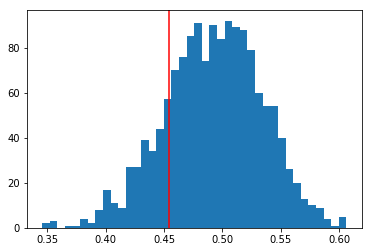

In [113]:
cantidad_bins = 40
plt.axvline(x=fraccion_mh_data,color ='r')
print("STD:",np.std(array_fraccion))

hist, bin_edges = np.histogram(array_fraccion,bins=cantidad_bins)
plt.hist(array_fraccion,bins=cantidad_bins)
print(hist)
#print(bin_edges)
#print(array_fraccion)

In [110]:
def calcula_pvavlue(hist):
    bin_size = bin_edges[1]-bin_edges[0]
    i=0
    suma_parcial=0.0
    while i<=find_nearest(bins,fraccion_mh_data):
        suma_parcial += hist[i]*bin_size
        i+=1

    i=0
    suma_total=0.0
    while i<len(hist):
        suma_total += hist[i]*bin_size
        i+=1  
    valor_p = suma_parcial/suma_total
    return valor_p
valor_p = calcula_pvavlue(hist)
print("Valor p:",round(valor_p,4))

('Valor p:', 0.0033)
